# Image Captioning

This is the project for Deep Learning using Tensorflow: [Project Proposal](https://sharedcare.io/ImageCaptioning/proposal/)

# Prepare the Training Data
##### Location to save the MSCOCO data.
MSCOCO_DIR="data/mscoco"

##### Run the preprocessing script.
sh ./download_and_preprocess_mscoco.sh \${MSCOCO_DIR}

##### Build the vocabulary.
DATA_DIR="mscoco/raw-data"

OUTPUT_DIR="mscoco/output"

python build_mscoco_data.py --train_image_dir=\${DATA_DIR}/train2014/ --val_image_dir=\${DATA_DIR}/val2014/ --train_captions_file=\${DATA_DIR}/annotations/captions_train2014.json --val_captions_file=\${DATA_DIR}/annotations/captions_val2014.json --output_dir=\${OUTPUT_DIR}/ --word_counts_output_file=\${OUTPUT_DIR}/word_counts.txt


# Download the Inception v3 Checkpoint
##### Location to save the Inception v3 checkpoint.
INCEPTION_DIR="data"

mkdir -p ${INCEPTION_DIR}

wget "http://download.tensorflow.org/models/inception_v3_2016_08_28.tar.gz"

tar -xvf "inception_v3_2016_08_28.tar.gz" -C ${INCEPTION_DIR}

rm "inception_v3_2016_08_28.tar.gz"

# Train a Model
##### Directory containing preprocessed MSCOCO data.
MSCOCO_DIR="data/data/mscoco"

##### Inception v3 checkpoint file.
INCEPTION_CHECKPOINT="data/inception_v3.ckpt"

##### Directory to save the model.
MODEL_DIR="model"

##### Train the model.
(tensorflow) device:im2txt user\$ python train.py --input_file_pattern="\${MSCOCO_DIR}/train-?????-of-00256" --inception_checkpoint_file="\${INCEPTION_CHECKPOINT}" --train_dir="\${MODEL_DIR}/train" --train_inception=false --number_of_steps=1000000

##### ＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿ Divider ＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿

# Using pre-trained models
First, we need to extract the tag from image using image recognition network.
Hence, we use [Interception V4](http://arxiv.org/abs/1602.07261) model for this project. To fit our purpose, we need use pre-trained models.
The code for train a Interception V4 model is avaliable [here](https://github.com/tensorflow/models/blob/master/research/slim/nets/inception_v4.py) and the pre-trained model is avaliable [here](http://download.tensorflow.org/models/inception_v4_2016_09_09.tar.gz).

### Download the Inception V4 checkpoint

In [7]:
import tensorflow as tf
from datasets import dataset_utils

url = "http://download.tensorflow.org/models/inception_v4_2016_09_09.tar.gz"
checkpoints_dir = './tmp/checkpoints'

if not tf.gfile.Exists(checkpoints_dir):
    tf.gfile.MakeDirs(checkpoints_dir)

dataset_utils.download_and_uncompress_tarball(url, checkpoints_dir)

>> Downloading inception_v4_2016_09_09.tar.gz 99.7%

### Apply Pre-trained Inception V4 model to Images.

INFO:tensorflow:Restoring parameters from ./tmp/checkpoints/inception_v4.ckpt


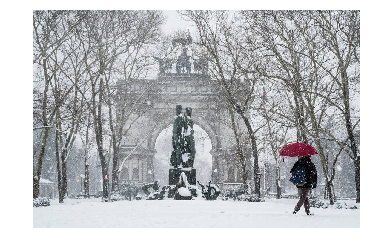

Probability 99.83% => [umbrella]
Probability 0.03% => [fountain]
Probability 0.00% => [trench coat]
Probability 0.00% => [bell cote, bell cot]
Probability 0.00% => [triumphal arch]


In [22]:
import numpy as np
import os
import tensorflow as tf
import matplotlib.pyplot as plt

try:
    import urllib2 as urllib
except ImportError:
    import urllib.request as urllib

from datasets import imagenet
from nets import inception_v4
from nets.inception_v4 import inception_v4
from nets.inception_v4 import inception_v4_arg_scope
from nets.inception_v4 import inception_v4_base
from preprocessing import inception_preprocessing

from tensorflow.contrib import slim

image_size = inception_v4.default_image_size

with tf.Graph().as_default():
    # Get image from url
    url = 'https://static01.nyt.com/images/2018/04/02/nyregion/02nytoday1/02nytoday1-master768.jpg'
    image_string = urllib.urlopen(url).read()
    image = tf.image.decode_jpeg(image_string, channels=3)
    
    # Process and apply the pre-trained model on the image   
    processed_image = inception_preprocessing.preprocess_image(image, image_size, image_size, is_training=False)
    processed_images  = tf.expand_dims(processed_image, 0)
    
    # Create the model, use the default arg scope to configure the batch norm parameters.
    with slim.arg_scope(inception_v4_arg_scope()):
        logits, _ = inception_v4(processed_images, num_classes=1001, is_training=False)
    probabilities = tf.nn.softmax(logits)
    
    init_fn = slim.assign_from_checkpoint_fn(
        os.path.join(checkpoints_dir, 'inception_v4.ckpt'),
        slim.get_model_variables('InceptionV4'))
    
    with tf.Session() as sess:
        init_fn(sess)
        np_image, probabilities = sess.run([image, probabilities])
        probabilities = probabilities[0, 0:]
        sorted_inds = [i[0] for i in sorted(enumerate(-probabilities), key=lambda x:x[1])]
        
    plt.figure()
    plt.imshow(np_image.astype(np.uint8))
    plt.axis('off')
    plt.show()

    names = imagenet.create_readable_names_for_imagenet_labels()
    for i in range(5):
        index = sorted_inds[i]
        print('Probability %0.2f%% => [%s]' % (probabilities[index] * 100, names[index]))

### Conclusion on Interception V4
As we apply the Interception V4 model to a image, we can get the tags with probabilities describing specific image.